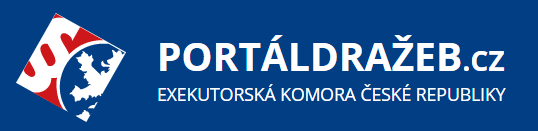

### Dynamic scraper
#### Goal
As the title suggests, the first section incorporates a data scraper. Its goal is to crawl through https://www.portaldrazeb.cz and to collect actual data about auctions and auctioneers. It also scrapes lists of auction attributes which we will subsequently use to filter the auctions with respect to location, type, etc.  
#### Problem
The problem is that the webpage has dynamic content and therefore we cannot easily extract the "static" source code as in other cases. The website also does not provide API (it actually does, however, not for us and not for the purposes we need). 
#### Solution
We use methods that handle the dynamic content - our solution is the installation of package *selenium* and setting up a *Google Chrome webdriver*. We basically open the webpage, collect its source code and navigate between pages. Thanks to this package (and the webdriver which is also included in the GitHub repository) we manage to download all the data we need. More detailed description of particular methods can be found in the class docstring and in the comments.

In [1]:
# importing the class which will do the scraping  
from dynamic_scraper import DataDownloader
down = DataDownloader() # initialising the scraper

Downloader successfully initialized!
 

    This class crawls through dynamic content of https://www.portaldrazeb.cz and collects following things:

            1) soup object for every auctioneer
            2) link to every auction + auction category (since the category is not within the auction page itself)
            3) list of all possible values from drop-down menu (auction categories, regions and districts)
    
    Subsequently it extracts soup objects of all auctions from the links collected in 2).
    


In [2]:
# link we will need
url_auctions='https://www.portaldrazeb.cz/drazby/pripravovane'

The next lines of code will scrape the data. Please do not interact with the Google Chrome window that will open in the background, just wait until it does its job and closes. The whole procedure should take a bit over 20 minutes. 

In [3]:
down.get_auction_links_and_categories(url_auctions) # takes approx. 5 minutes

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [05:28<00:00,  5.76s/it]


Auction links and categories successfully downloaded! There are 1125 auctions right now.


In [4]:
down.get_items_from_dropdown_menu(url_auctions) #needs Chrome version 90 (exactly this one)

Auction categories, regions and districts successfully downloaded!


In [5]:
down.extract_auction_soups() # takes approx. 17 minutes

100%|██████████████████████████████████████████████████████████████████████████████| 1125/1125 [18:06<00:00,  1.04it/s]

Soup objects successfully appended to auction_links_and_categories.


### Data processor
#### Goal
The second section contains the data processor. It accepts BeautifulSoup objects scraped in first part and extracts information about every auction. Closer information of what is collected can be found in the class description.
#### Problem
Variables in which we are interested in are scattered through the long strings. Luckily, the structure of string remains fairly consistent from auction to auction and mostly there is some substring preceding the desired information which we can find and look some constant amount of characters behind it. Also, there is a problem with Czech characters, which are encoded in a different way than we need them.
#### Solution
This problem demands an approach focused on specifics of every variable, so all necessary data were found, cleaned and put into Pandas dataframe and then a CSV file. 

In [6]:
# importing the class which will process the data
from data_processor import DataProcessor
processor = DataProcessor() # initialising the class

Processor successfully initialized!
 

    This class iterates over all soup objects returned by data scraper and collects following information about every auction:
    1) auctioneer, his/her phone and e-mail address
    2) the municipality and region (kraj) where the auction is held and GPS coordinates of the point
    3) title - what is being auctioned
    4) time when the auction begins
    5) category and subcategory to which the auctioned object belongs
    6) unique code of the auction
    7) Reserve price (vyvolávací cena) and estimated price (odhadnutá cena) of the auctioned object
    8) Link to the auction in the registry 
    


In [7]:
processor.process_data(down.auction_links_and_categories,down.regions_and_districts)

Data successfully processed!


### Data explorer & filter
#### Goal
Now we come to the last part of our project, i.e. loading the final dataset and exploring its content using maps and graphs. Subsequently, we create a small dashboard that displays two widgets which enable us to filter the auctions with respect to region and district or with respect to category. 
#### Maps
All maps show larger values as lighter shades. The districts are coloured in this way: The region or district with the largest respective value has shade #999999 (light grey) in maps counting auctions or #009900 (light green) in maps showing average price. All other regions or districts are colored by shade of grey or green based on how many percent of maximum value does that place have, e.g. a region in which there are 42% of auctions of the largest regional amount will have colour #424242. (darker grey).
#### Filters
We use two drop-down menus that simultaneously filter our dataset, either according to region and district or according to category and subcategory. The code is, however, not the smartest one and therefore we had to separate the filters into two parts and did not use them together. The output includes three tabs that display a filtered data set, a pie chart of the data and a histogram of auctioneers. All parts dynamically change when other value is selected.

#### Map displaying number of auctions and average price of auction within region

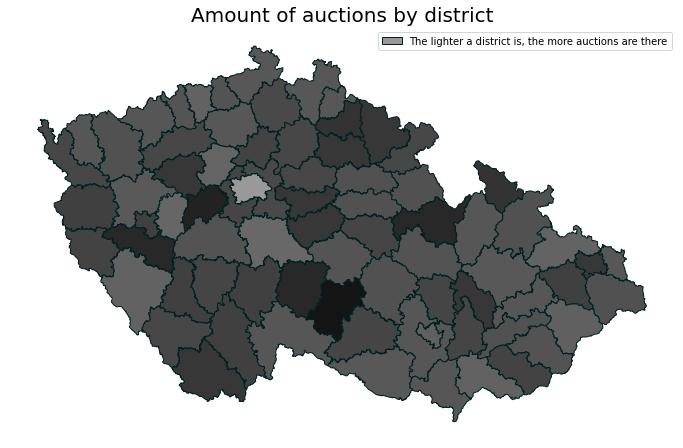

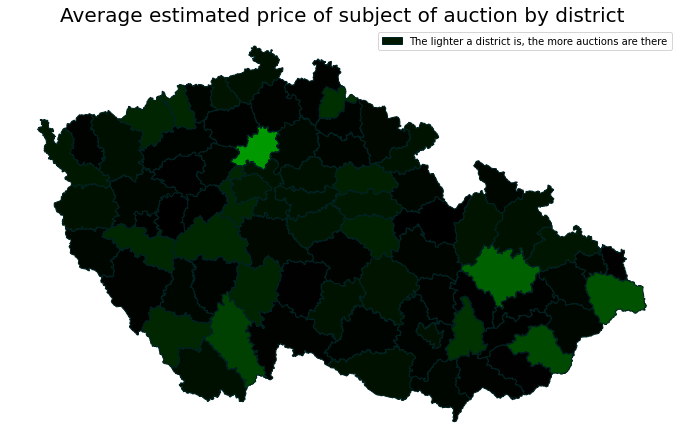

In [8]:
%run map_plotter 

#### Filter according to auction region and district

In [9]:
%run data_filter_location

#### Filter according to auction category and subcategory

In [10]:
%run data_filter_category